In [1]:
# setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex2 import *

#import libraries
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

#specify csv file-path
data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/store-sales-time-series-forecasting')

#us-retail-sales-dataframe
retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'], #to recognize as date-time "value"
    infer_datetime_format=True,
)
#pre-process store_sales - dataframe
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

/opt/conda/lib/python3.10/site-packages/learntools/time_series/checking_utils.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [30]:
#retail_sales dataframe
retail_sales

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01-01,6938,3657,29589,26788,14996,8964
1992-02-01,7524,3490,28570,28203,16015,9023
1992-03-01,8475,3669,29682,31684,17984,10608
1992-04-01,9401,3527,30228,32547,18872,11630
1992-05-01,9558,3571,31677,32883,20037,12327
...,...,...,...,...,...,...
2019-08-01,23829,7519,66937,105884,61777,32375
2019-09-01,19567,7123,62420,91758,54785,29963
2019-10-01,21400,7096,64849,95219,58872,32629


In [35]:
#store_sales dataframe
store_sales

id        sales  \
date       store_nbr family                                             
2013-01-01 1         AUTOMOTIVE                        0     0.000000   
                     BABY CARE                         1     0.000000   
                     BEAUTY                            2     0.000000   
                     BEVERAGES                         3     0.000000   
                     BOOKS                             4     0.000000   
...                                                  ...          ...   
2017-08-15 9         POULTRY                     3000883   438.132996   
                     PREPARED FOODS              3000884   154.552994   
                     PRODUCE                     3000885  2419.729004   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000000   
                     SEAFOOD                     3000887    16.000000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

-------------------------------------------------------------------------------

## Trend with a Moving Average 

The *US Retail Sales* dataset contains monthly sales data for a number of retail industries in the United States.

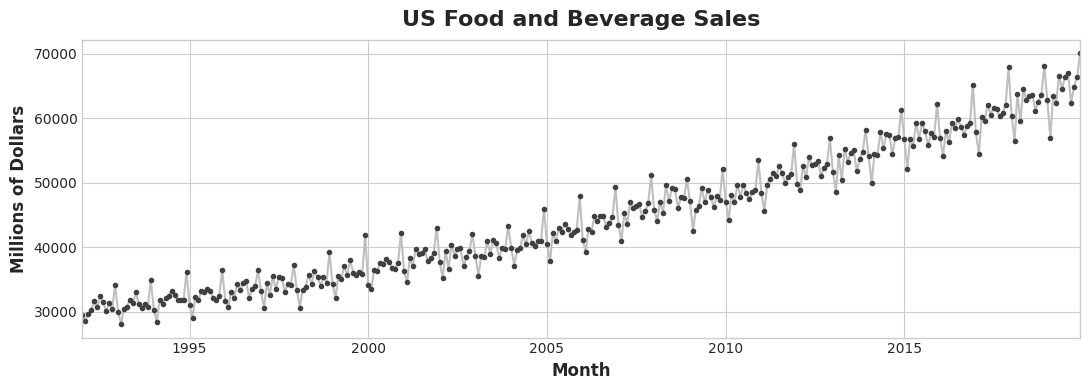

In [2]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

Now make a moving average plot to estimate the trend for the series.

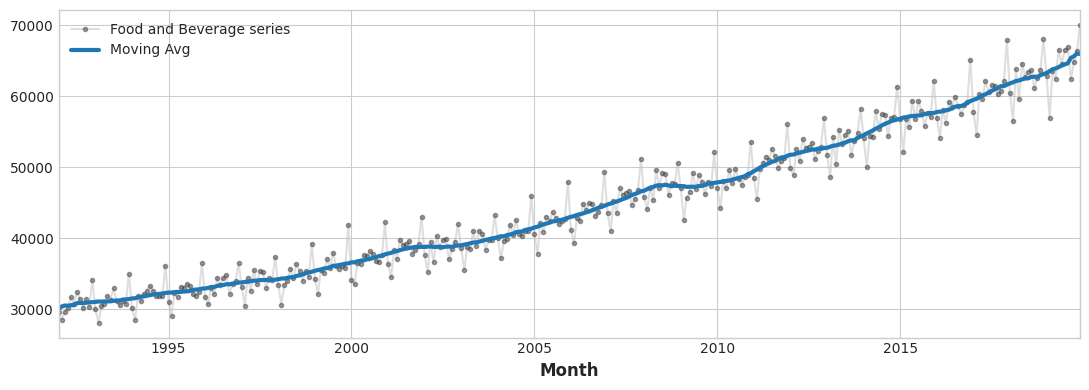

In [36]:
trend = food_sales.rolling(
window=12, #as parse_dates = 'Month' -> 12 month window
center=True,
min_periods=6,#usually 1/2 * window size
).mean()

ax = food_sales.plot(**plot_params, alpha=0.5, label='Food and Beverage series') #alpha=0.5: plotted data semi-transparent
ax = trend.plot(ax=ax, linewidth=3,label='Moving Avg')
ax.legend()
plt.show()

-------------------------------------------------------------------------------

## Identifying Trend

Finding the correct order polynomial trend, that might be appropriate for the *Food and Beverage Sales* series. 

In [41]:
# 
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=food_sales.index, # dates from the training data
    constant=True,         # dummy feature for the bias (y_intercept)
    order=2,              # time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# `in_sample` create features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared
Month,,,
1992-01-01,1.0,1.0,1.0
1992-02-01,1.0,2.0,4.0
1992-03-01,1.0,3.0,9.0
1992-04-01,1.0,4.0,16.0
1992-05-01,1.0,5.0,25.0


Growth rate in "Food and Beverage Sales" is best expressed as a percent change. Percent change can often be modeled using an exponential curve.

-------------------------------------------------------------------------------
## Moving Average Plot of `average_sales` Estimating the Trend

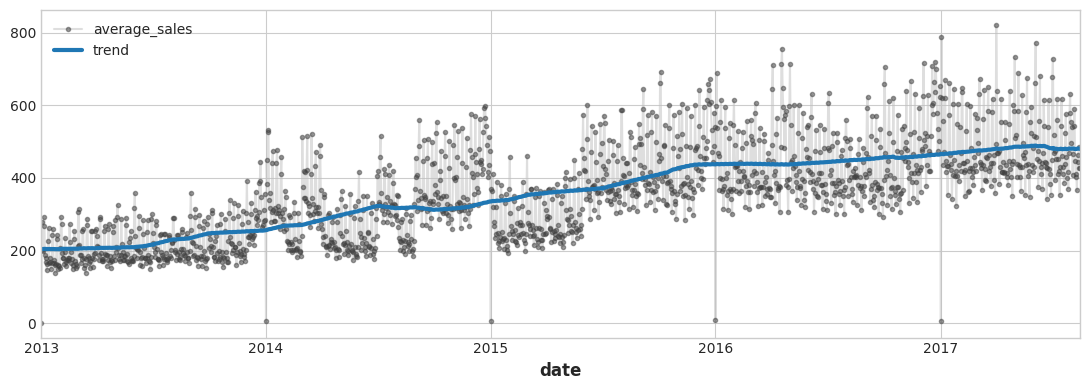

In [65]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5, label='average_sales')
ax = trend.plot(ax=ax, linewidth=3, label='trend')
ax.legend()

## Creating a Trend Feature using Deterministic Process

Using `DeterministicProcess` to create a feature set for a cubic trend model and create features for a 90-day forecast.

In [66]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

#generate features based on time up to t**3 terms:
dp = DeterministicProcess(
    index=y.index,
    order=3 #cubic trend
)

X = dp.in_sample() #generate features (X) for the in-sample period, covering the same time range as the target variable

#create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

## **Linear Regression Model:**


--------------------------------------------------------------------------------
Use features `X` & `X_fore` to capture trend and make forecast. One way to fit more complicated trends is to increase the order of the polynomial. To get a better fit to the somewhat complicated trend in `store_sales`, we could compare `order 2` with `order 11` polynomial.

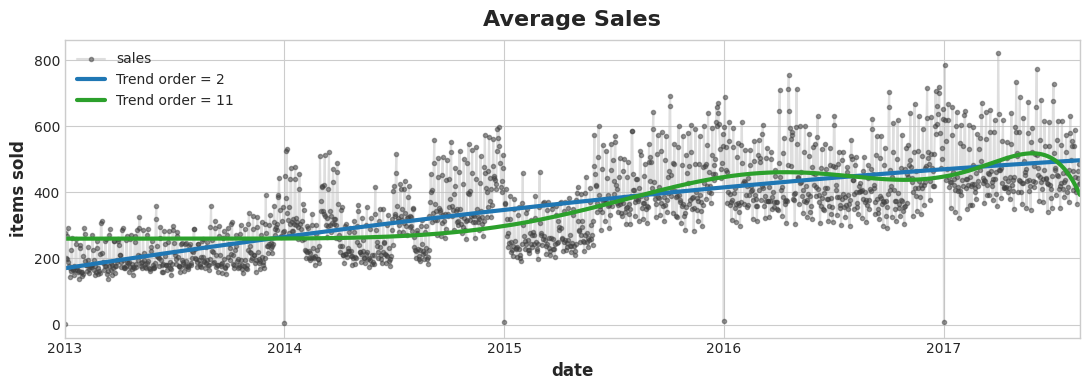

In [55]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp_2 = DeterministicProcess(index=y.index, order=2)
dp_11 = DeterministicProcess(index=y.index, order=11)

X_2 = dp_2.in_sample()
X_11 = dp_11.in_sample()

model_2 = LinearRegression()
model_2.fit(X_2, y)

model_11=LinearRegression()
model_11.fit(X_11, y)

y_pred_2 = pd.Series(model_2.predict(X_2), index=X_2.index)
y_pred_11 = pd.Series(model_11.predict(X_11), index=X_11.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred_2.plot(ax=ax, linewidth=3, label="Trend order = 2", color='C0')
ax = y_pred_11.plot(ax=ax, linewidth=3, label="Trend order = 11", color='C2')
ax.legend();

## Understand Risks of Forecasting with High-order polynomials


High-order polynomials are generally not well-suited to forecasting. As we move away from the time points where the model was trained, the values of these high-degree polynomial terms can become extremely large, leading to unreliable forecasts. An order of 11, i.e., (t ** 11) polynomial will include terms like `t ** 11` which tend to diverge rapidly outside of the training period making forecasts very unreliable.



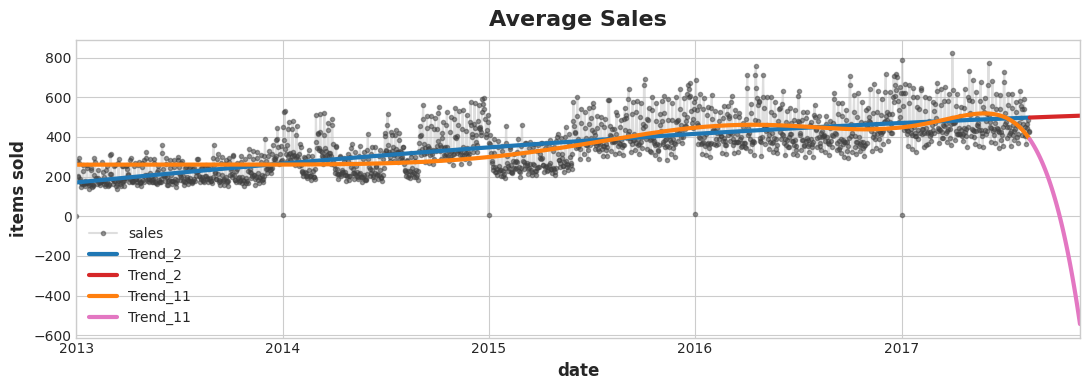

In [62]:
X_fore_2 = dp_2.out_of_sample(steps=90)
y_fore_2 = pd.Series(model_2.predict(X_fore_2), index=X_fore_2.index)

X_fore_11 = dp_11.out_of_sample(steps=90)
y_fore_11 = pd.Series(model_11.predict(X_fore_11), index=X_fore_11.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred_2.plot(ax=ax, linewidth=3, label="Trend_2", color='C0')
ax = y_fore_2.plot(ax=ax, linewidth=3, label="Trend_2", color='C3')
ax = y_pred_11.plot(ax=ax, linewidth=3, label="Trend_11", color='C1')
ax = y_fore_11.plot(ax=ax, linewidth=3, label="Trend_11", color='C6')
ax.legend();